## Running and Processing a SWMMIN Simulation

In this notebook, we go over an example of running and processing a SWMMIN simulation created by either the ```Conversion_to_SWMMIN.ipynb``` notebook or the ```Convert_to_SWMMIN()``` method of the ```SWMMIN_sim()``` class.  

The execution of the SWMM simulation is done using PySWMM [[1]](#references).  

After execution, the output is processed and a few visualization and post-processing tools are showcased.

### Importing Required Packages

In [28]:
import pyswmm
import re
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import pathlib

### Specifying SWMMIN input file
In this notebook the SWMMIN input file must be input directly.  
In the GOSWMMIN package, the SWMMIN_sim() class contains the input file path and the file can be executed directly using ```SWMMIN_sim().Run_SWMMIN()```

In [29]:
 # Replace with appropriate path and filename
directory=pathlib.Path('../Networks/Linear Network/')
filename=pathlib.Path('Linear_Network_SWMMIN_100m.inp')
name_only='_'.join(str(filename).split('_')[0:2])
print("Selected File: ",name_only)
path=directory/filename

Selected File:  Linear_Network


##### Open the SWMM simulation using PySWMM
Specifying the path for the input file and the future/current output file (.out) where the results are stored

In [30]:
sim=pyswmm.Simulation (str(path), outputfile=str(path.with_suffix(".out")))

##### Read the IDs of demand nodes (Notebook only)
Find the list of ids for demand nodes by identifying user storage nodes. In the GOSWMMIN package, this information is stored in the object

In [31]:
# Load the nodes object from the simulation
nodes=pyswmm.nodes.Nodes(sim)
# Initialize list of tank IDs
tankids=[]
# Loop through all nodes and find the tank IDs that start with StorageforNode
for node in nodes:
    if re.search('StorageforNode',node.nodeid):
        tankids.append(node.nodeid)

# Extract the demand node IDs from the tank IDs
demand_node_ids=[x[14:] for x in tankids]
# Create the withdrawal and consumption outlet IDs
Withdraw_ids = ["Outlet" + x for x in demand_node_ids]
Consume_ids = ["DemandOutlet" + x for x in demand_node_ids]

##### Run the SWMMIN simulation using PySWMM 

Using PySWMM, execute the input file and display progress updates and a final value for the continuity error.  
Tis cell can be skipped if the input file has already been run before and a .out file already exists with the intended simulation's results

In [32]:
stp=0       #steps counter
every=1000  #Interval of printing current time

# runs the simulation step by step
with sim as sim:
    system_routing = pyswmm.SystemStats(sim)
    for step in sim:
        if stp%every==0:
            print('Current Simulation Time is >> ',sim.current_time,", ",round(sim.percent_complete*100,1),"% Complete")

        stp+=1
        pass
    sim._model.swmm_end()
    print("Continuity Error: ",sim.flow_routing_error,"%\n")

Current Simulation Time is >>  2022-05-18 00:00:00 ,  0.0 % Complete
Current Simulation Time is >>  2022-05-18 00:16:40 ,  1.2 % Complete
Current Simulation Time is >>  2022-05-18 00:33:20 ,  2.3 % Complete
Current Simulation Time is >>  2022-05-18 00:50:00 ,  3.5 % Complete
Current Simulation Time is >>  2022-05-18 01:06:40 ,  4.6 % Complete
Current Simulation Time is >>  2022-05-18 01:23:20 ,  5.8 % Complete
Current Simulation Time is >>  2022-05-18 01:40:00 ,  6.9 % Complete
Current Simulation Time is >>  2022-05-18 01:56:40 ,  8.1 % Complete
Current Simulation Time is >>  2022-05-18 02:13:20 ,  9.3 % Complete
Current Simulation Time is >>  2022-05-18 02:30:00 ,  10.4 % Complete
Current Simulation Time is >>  2022-05-18 02:46:40 ,  11.6 % Complete
Current Simulation Time is >>  2022-05-18 03:03:20 ,  12.7 % Complete
Current Simulation Time is >>  2022-05-18 03:20:00 ,  13.9 % Complete
Current Simulation Time is >>  2022-05-18 03:36:40 ,  15.1 % Complete
Current Simulation Time is >>

### Analyzing Demand Satisfaction in the Network  

As an example of the postprocessing and vizualization that can be done in GOSWMMMIN (with more in development), we demonstrate a demand satisfaction analysis tool.  
First, the demand information: both withdrawal and consumption rates are extracted from the output.

In [56]:
WithdrawRates=pd.DataFrame()   #Empty Dataframe to store water depth in tanks
ConsumeRates=pd.DataFrame()   #Empty Dataframe to store water depth in nodes
swtch=True                   # switch variable for upcoming condition

# Reads the output file created above
with pyswmm.Output(str(path.with_suffix(".out"))) as out:
    # loops through each node in output file
    for link in out.links:

        # One time only. Gets the timesteps (the keys in the output series dictionary) and stores them to be used as index
        if swtch:
        # node_series produces a dictionary with the keys corresponding to timestamps and values contain the value of the selected variable (FLOW_RATE) at each timestamp
            index = pd.Series(out.link_series(link, 'Flow_rate').keys())
            WithdrawRates.loc[:,"time"]=index
            ConsumeRates.loc[:,"time"]=index
            swtch=False
        
        # If node id is in the prepared list of demand nodes (tanks)
        if link in Withdraw_ids:
            WithdrawRates.loc[:,link[6:]] = out.link_series(link, 'Flow_rate').values()  
        elif link in Consume_ids:
            ConsumeRates.loc[:,link[12:]]= out.link_series(link, 'Flow_rate').values()

In [57]:
reporting_timestep = index.diff().dt.seconds.mode()[0] #reporting time step in seconds

If the simulation is more than one day, the cell below explores the withdrawal rate based satisfaction rate and the consumption based satisfaction ratio in each day.  
These satisfaction ratios are defined as:  
$$SR_w = \frac{\Sigma Q_w(t) \Delta t}{V_{demand}}$$
and  
$$ SR_c = \frac{\Sigma Q_c(t) \Delta t}{V_{demand}}$$  
where $SR_w$ and $SR_c$ are the withdrawal and consumption based SR respectively

In [58]:
# Initialize Data Frames for Satisfaction Ratios
Withdraw_by_Day = WithdrawRates.groupby(pd.Grouper(key = 'time', freq = 'D'))

Consumer_by_Day = ConsumeRates.groupby(pd.Grouper(key = 'time', freq = 'D'))

Daily_Totals_W = WithdrawRates.groupby(pd.Grouper(key = 'time', freq = 'D')).sum().T*reporting_timestep / 1000
Daily_Totals_C = ConsumeRates.groupby(pd.Grouper(key = 'time', freq = 'D')).sum().T*reporting_timestep / 1000

In [59]:
Daily_Totals_W

time,2022-05-18
DN1,1456.253947
DN2,1473.762461
DN3,644.289193
DN4,690.626618


In [60]:
demand_volumes = pd.read_csv(directory/pathlib.Path(name_only+'_DemandVolumes.csv')).set_index(Daily_Totals_W.index)

Daily_Satis_W = pd.DataFrame(columns=Daily_Totals_W.columns, index = Daily_Totals_W.index)
Daily_Satis_C = pd.DataFrame(columns = Daily_Totals_C.columns, index = Daily_Totals_C.index)
for column in range(len(Daily_Totals_W.columns)):
        Daily_Satis_W.iloc[:,column] = Daily_Totals_W.iloc[:,column] / demand_volumes['Volume']*100
for column in range(len(Daily_Totals_C.columns)):
        Daily_Satis_C.iloc[:,column] = Daily_Totals_C.iloc[:,column] / demand_volumes['Volume']*100

In [61]:
Daily_Satis_W, Daily_Satis_C

(time 2022-05-18
 DN1   75.846559
 DN2   76.758461
 DN3   22.371153
 DN4   71.940273,
 time 2022-05-18
 DN1   75.844991
 DN2   76.755484
 DN3   22.368184
 DN4   71.937874)

(0.0, 100.0)

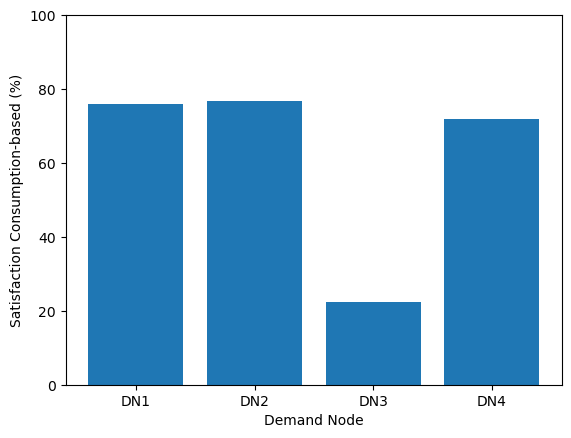

In [63]:
fig, ax  = plt.subplots()
ax.bar(Daily_Satis_W.index, Daily_Satis_W.mean(axis=1), label = 'Withdrawal Satisfaction')
ax.set_xlabel('Demand Node')
ax.set_ylabel('Satisfaction Consumption-based (%)')
ax.set_ylim(0,100)


### In-development Tools  
The following visualization and postprocessing tools are in development:  

1. A Water Balance summary tool
2. An effective supply duration tool

## References

[1] McDonnell, B., Ratliff, K., Tryby, M., Wu, J., & Mullapudi, A. (2020). PySWMM: The Python Interface to Stormwater Management Model (SWMM). Journal of Open Source Software, 5(52), 2292. https://doi.org/10.21105/joss.02292